2024-08-22 00:15:22.105567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 00:15:22.144526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 00:15:22.902302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
196/196 [==============================] - 4s 9ms/step - loss: 0.0201
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 7/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 8/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 9/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 10/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0151
Epoch 1/10
196/196 [==============================] - 4s 9ms/step - loss: 0.0164
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0116
Epoch 3/10
196/196 [=======

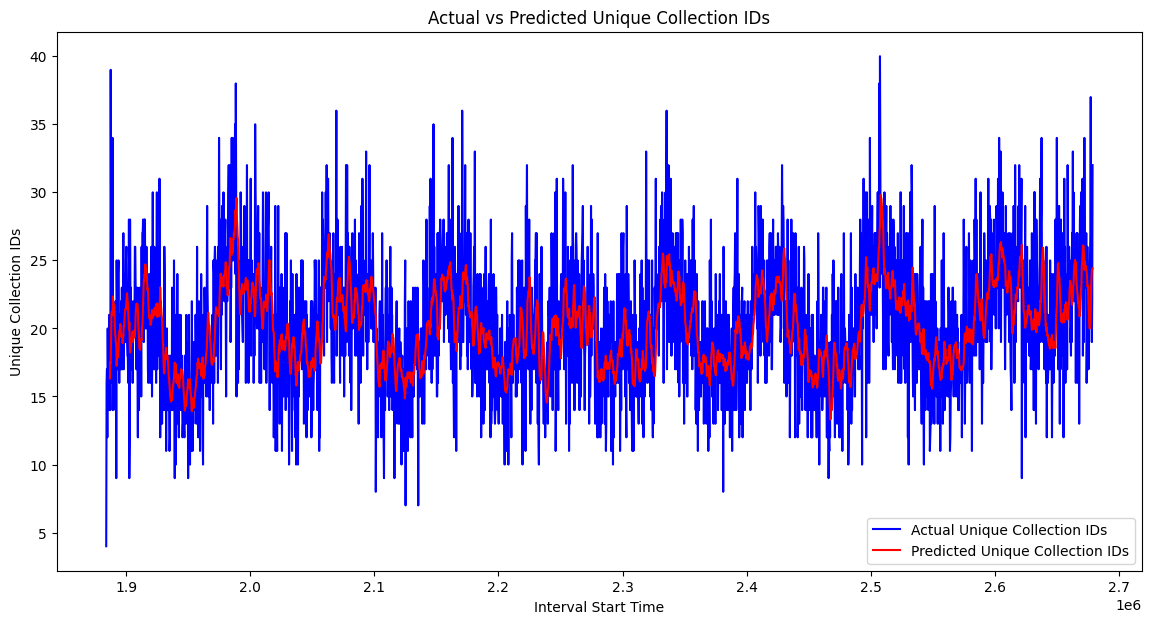

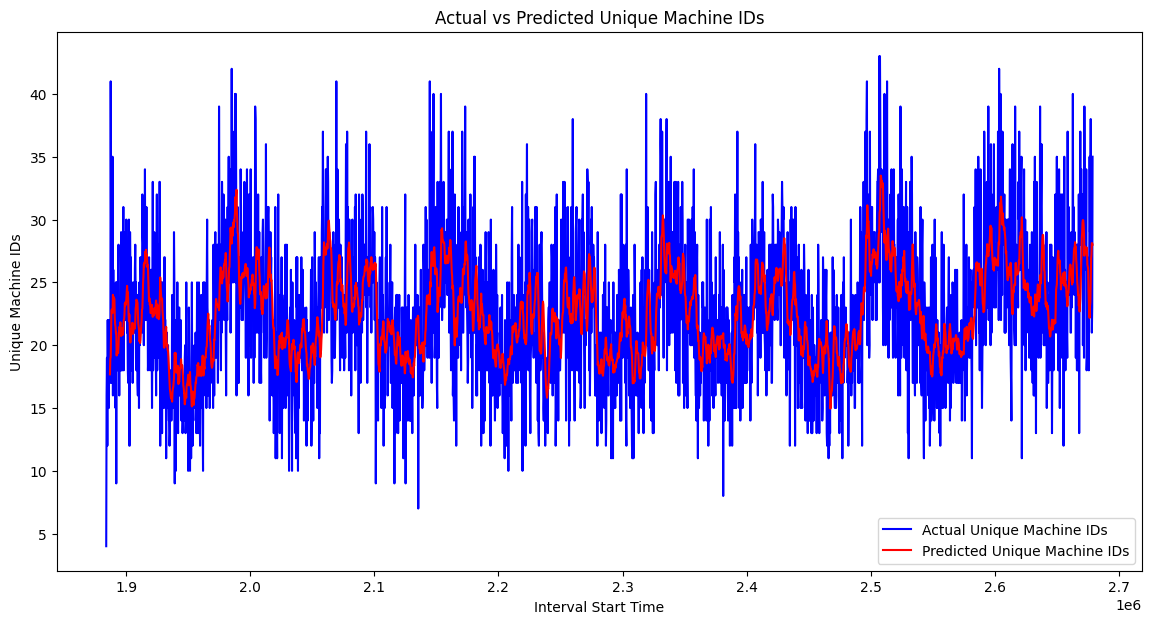

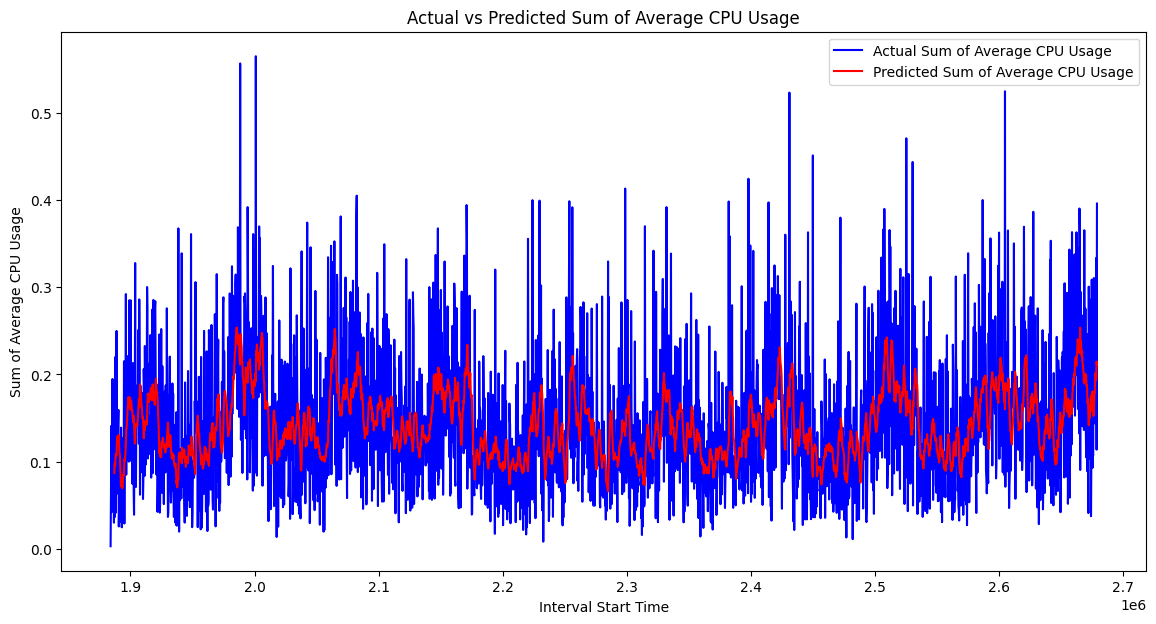

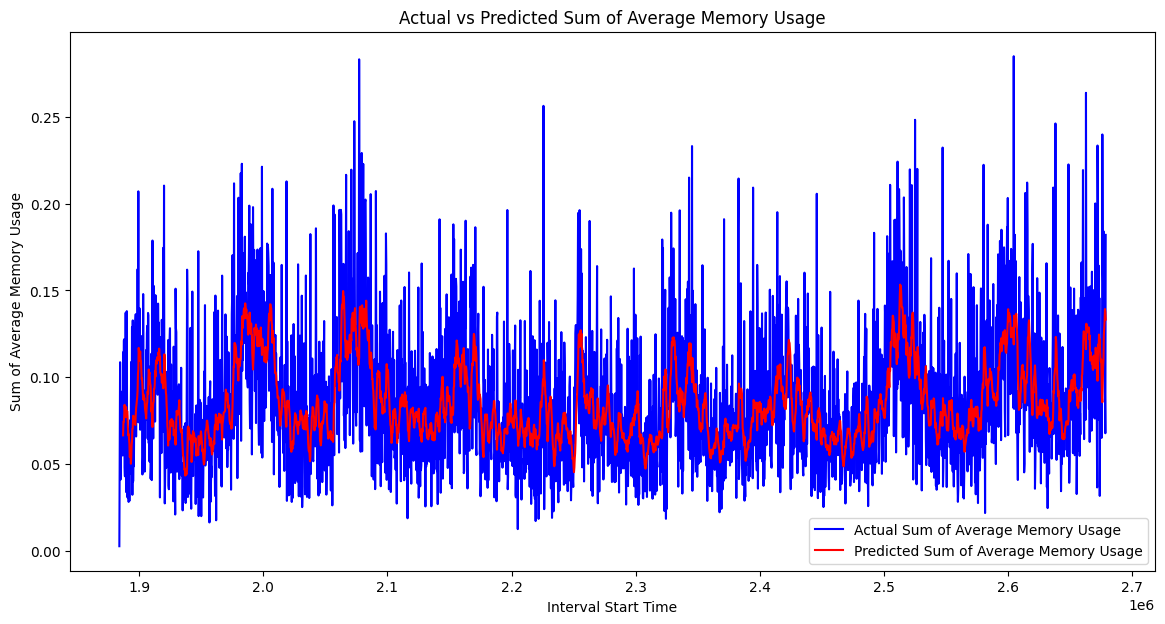

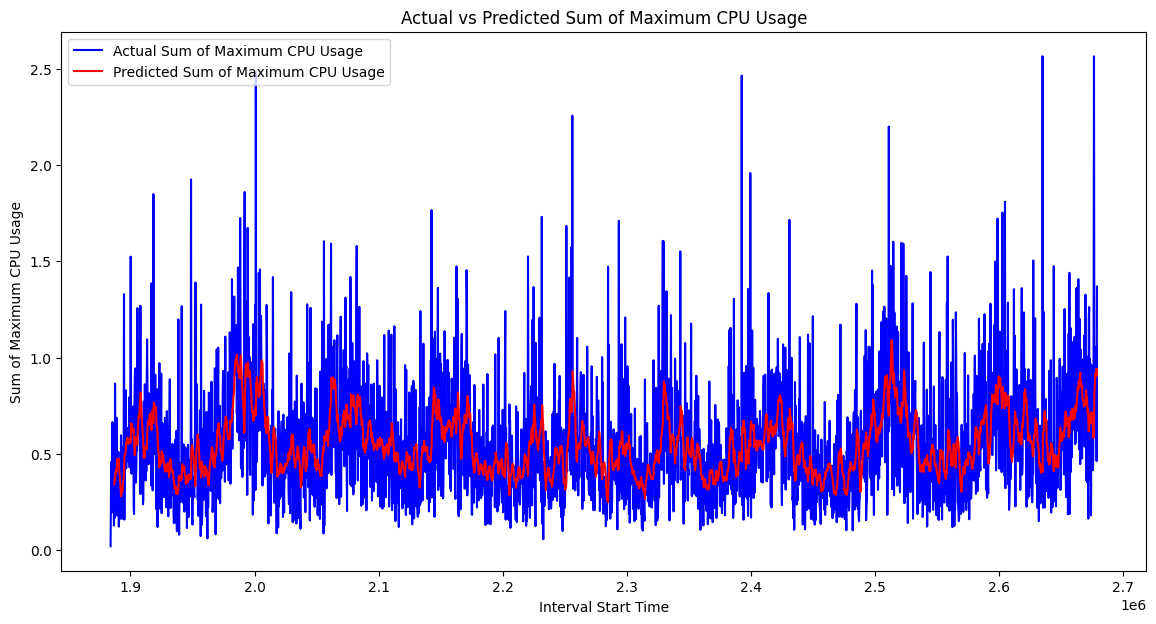

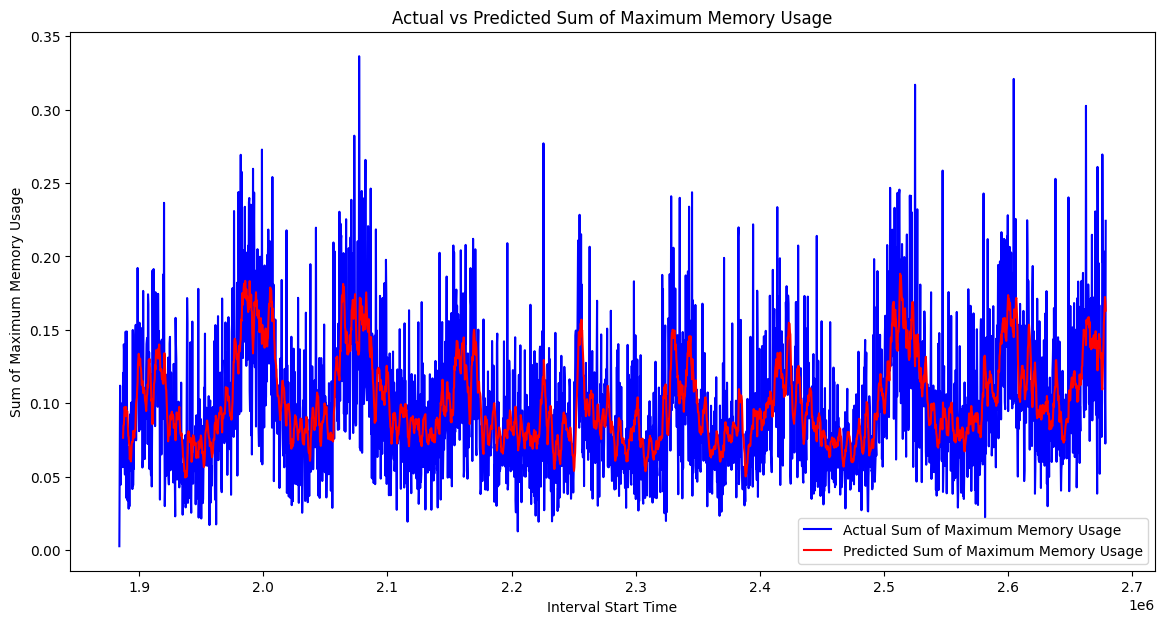

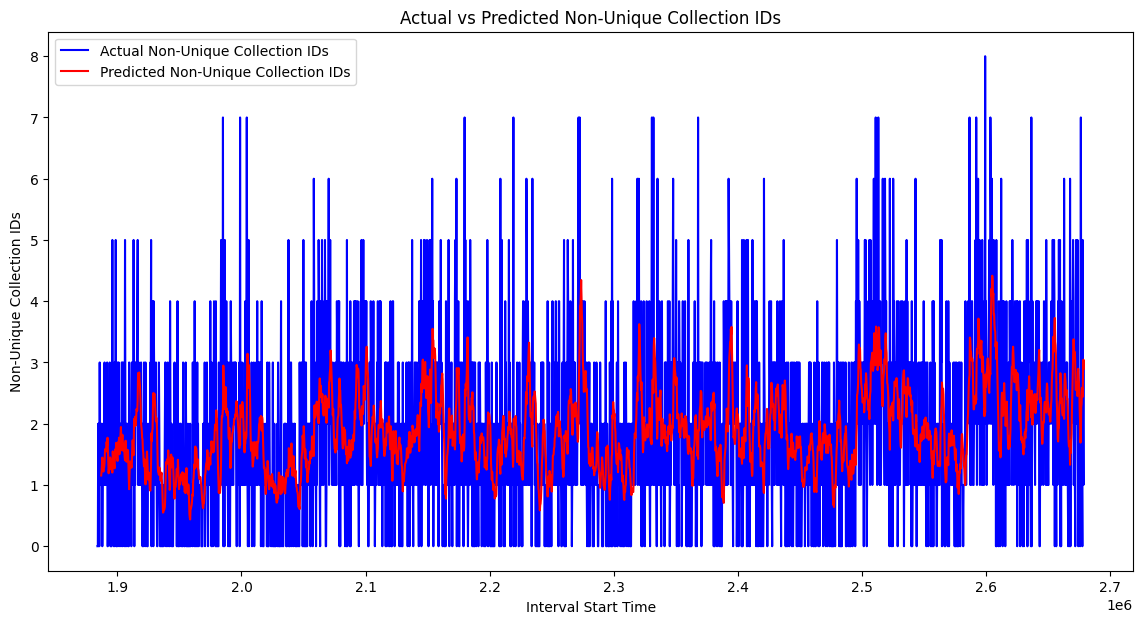

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length (300 seconds)
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()
    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def create_interval_features(df):
    start_time = df['start_time'].min()
    end_time = df['start_time'].max()
    current_start = start_time
    results = []
    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = df[(df['start_time'] >= current_start) & (df['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            interval_result['interval_end'] = current_end
            results.append(interval_result)
        current_start = current_end
    return pd.DataFrame(results)

# Split data into training (70%) and testing (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

# Process training data
train_intervals_df = create_interval_features(train_data)

# Prepare the target variables for LSTM models
train_targets = {
    'unique_collection_ids': train_intervals_df['unique_collection_ids'].values,
    'unique_machine_ids': train_intervals_df['unique_machine_ids'].values,
    'sum_avg_cpu': train_intervals_df['sum_avg_cpu'].values,
    'sum_avg_memory': train_intervals_df['sum_avg_memory'].values,
    'sum_max_cpu': train_intervals_df['sum_max_cpu'].values,
    'sum_max_memory': train_intervals_df['sum_max_memory'].values,
    'non_unique_collection_ids': train_intervals_df['non_unique_collection_ids'].values
}

# Normalize the target variables
scalers = {target: MinMaxScaler() for target in train_targets}
for target in train_targets:
    train_targets[target] = scalers[target].fit_transform(train_targets[target].reshape(-1, 1))

# Convert the training targets into sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

sequence_length = 10
train_sequences = {target: create_sequences(train_targets[target], sequence_length) for target in train_targets}

# Build LSTM models
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_models = {target: build_lstm_model((sequence_length, 1)) for target in train_targets}

# Train LSTM models
for target in lstm_models:
    X_train = train_sequences[target][:-1]
    y_train = train_sequences[target][1:]
    lstm_models[target].fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Process the testing data into intervals
test_intervals_df = create_interval_features(test_data)

# Prepare the actual values for predictions
actual_values = {
    'unique_collection_ids': test_intervals_df['unique_collection_ids'].values,
    'unique_machine_ids': test_intervals_df['unique_machine_ids'].values,
    'sum_avg_cpu': test_intervals_df['sum_avg_cpu'].values,
    'sum_avg_memory': test_intervals_df['sum_avg_memory'].values,
    'sum_max_cpu': test_intervals_df['sum_max_cpu'].values,
    'sum_max_memory': test_intervals_df['sum_max_memory'].values,
    'non_unique_collection_ids': test_intervals_df['non_unique_collection_ids'].values
}

# Normalize the actual values
for target in actual_values:
    actual_values[target] = scalers[target].transform(actual_values[target].reshape(-1, 1))

# Convert the testing targets into sequences for LSTM
test_sequences = {target: create_sequences(actual_values[target], sequence_length) for target in actual_values}

# Make predictions for the testing intervals
predictions = {}
for target in test_sequences:
    X_test = test_sequences[target]
    predictions[target] = lstm_models[target].predict(X_test)

# Invert normalization for actual and predicted values
for target in predictions:
    predictions[target] = scalers[target].inverse_transform(predictions[target])

# Add actual and predicted values to test intervals DataFrame
for target in actual_values:
    test_intervals_df[f'predicted_{target}'] = np.nan
    test_intervals_df[f'actual_{target}'] = scalers[target].inverse_transform(actual_values[target])
    test_intervals_df.loc[sequence_length:, f'predicted_{target}'] = predictions[target].flatten()

def plot_actual_vs_predicted(df, target, ylabel, title):
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='interval_start', y=f'actual_{target}', data=df, label=f'Actual {ylabel}', color='blue')
    sns.lineplot(x='interval_start', y=f'predicted_{target}', data=df, label=f'Predicted {ylabel}', color='red')
    plt.xlabel('Interval Start Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


plot_actual_vs_predicted(test_intervals_df, 'unique_collection_ids', 'Unique Collection IDs', 'Actual vs Predicted Unique Collection IDs')
plot_actual_vs_predicted(test_intervals_df, 'unique_machine_ids', 'Unique Machine IDs', 'Actual vs Predicted Unique Machine IDs')
plot_actual_vs_predicted(test_intervals_df, 'sum_avg_cpu', 'Sum of Average CPU Usage', 'Actual vs Predicted Sum of Average CPU Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_avg_memory', 'Sum of Average Memory Usage', 'Actual vs Predicted Sum of Average Memory Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_max_cpu', 'Sum of Maximum CPU Usage', 'Actual vs Predicted Sum of Maximum CPU Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_max_memory', 'Sum of Maximum Memory Usage', 'Actual vs Predicted Sum of Maximum Memory Usage')
plot_actual_vs_predicted(test_intervals_df, 'non_unique_collection_ids', 'Non-Unique Collection IDs', 'Actual vs Predicted Non-Unique Collection IDs')


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def calculate_metrics(df, target):
    actual = df[f'actual_{target}'][sequence_length:].values.flatten()
    predicted = df[f'predicted_{target}'][sequence_length:].values.flatten()

    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return mse, mae, rmse, mape

for target in actual_values.keys():
    mse, mae, rmse, mape = calculate_metrics(test_intervals_df, target)
    print(f'{target}:\n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n MAPE: {mape}\n')


unique_collection_ids:
 MSE: 19.846154343299048
 MAE: 3.5425248077421476
 RMSE: 4.454902282126854
 MAPE: 18.644640387142424

unique_machine_ids:
 MSE: 27.779624937212517
 MAE: 4.192412602540219
 RMSE: 5.270638000964638
 MAPE: 20.1057318343362

sum_avg_cpu:
 MSE: 0.005865755646601269
 MAE: 0.05906309102045263
 RMSE: 0.07658822133070639
 MAPE: 57.83436295802657

sum_avg_memory:
 MSE: 0.0014742811940832738
 MAE: 0.029602558512955453
 RMSE: 0.03839636954300854
 MAPE: 40.34392067531336

sum_max_cpu:
 MSE: 0.09116879474457298
 MAE: 0.2224029077351719
 RMSE: 0.3019417075274183
 MAPE: 53.00719064526278

sum_max_memory:
 MSE: 0.0017884338493798597
 MAE: 0.03315938004120651
 RMSE: 0.04228987880545249
 MAPE: 41.97040270771398

non_unique_collection_ids:
 MSE: 1.9758343478355214
 MAE: 1.110315258213968
 RMSE: 1.4056437485492266
 MAPE: inf



/tmp/ipykernel_1289742/1028468665.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100
